In [131]:
# first import all necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_boston

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Layer

from keras.initializers import Initializer
from keras.initializers import Constant
from keras.layers import Dense
from keras import backend as K

from __future__ import print_function, absolute_import, division
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.cluster import KMeans
import torch.nn.functional as F
from sklearn import preprocessing

In [132]:
# import boston dataset 
x_train= load_boston()
print(x_train.feature_names)
data=pd.DataFrame(x_train.data,columns=x_train.feature_names)
data['PRICE']=x_train.target
target = data['PRICE']
data.describe()

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [134]:
rooms = data.RM
price = data.PRICE
rooms = np.array(rooms).reshape(-1,1)
price = np.array(price).reshape(-1,1)
#print(rooms,price)
prices = data['PRICE']
features = data.drop('PRICE', axis = 1)

In [136]:
#The Boston housing dataset is split into training and testing subsets, with the given analogy of 75-25 %
X_train, X_test, Y_train, Y_test = train_test_split(rooms, price, test_size = 0.25, random_state=5)
split_size = int(X_train.shape[0]*0.8)
X_train, X_val = X_train[:split_size], X_train[split_size:]
Y_train, Y_val = Y_train[:split_size], Y_train[split_size:]
# define three number of hidden layer neurons as required
num_neurons_1=round(0.1*len(X_train))
num_neurons_2=round(0.5*len(X_train))
num_neurons_3=round(0.9*len(X_train))
#print(X_train,X_test)

In [137]:
#ok
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """
    def __init__(self, X, max_iter=100):
        self.X = X 
        self.max_iter = max_iter
        
    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0] 
        km= KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=1)
        km.fit(self.X)
        return km.cluster_centers_

In [138]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

In [139]:
class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),trainable=True)
                                     # initializer='ones',
                                     
        super(RBFLayer, self).build(input_shape)
    def initialize_stds(self,X):
        self.centers, _ = kmeans(X, self.output_dim)
        dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.stds = np.repeat(dMax / np.sqrt(2*self.output_dim), self.output_dim)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [140]:
#define first model

output_number=128
#optimizer
learning_rate=0.001
opt=tf.keras.optimizers.SGD(learning_rate=learning_rate)

rbflayer1 = RBFLayer(num_neurons_1,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))
rbflayer2 = RBFLayer(num_neurons_2,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))
rbflayer3 = RBFLayer(num_neurons_3,initializer=InitCentersKMeans(X_train),betas=2,input_shape=(1,))

#initialize rbf layer's
rbflayer1.initialize_stds(X_train)
rbflayer2.initialize_stds(X_train)
rbflayer3.initialize_stds(X_train)

#define first network 

model_1=tf.keras.Sequential()
model_1.add(rbflayer1)
model_1.add(layers.Dense(output_number))
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt,metrics=['accuracy'])
history_1=model_1.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Initialization complete
Iteration 0, inertia 0.3381540000000006
Iteration 1, inertia 0.2857206049145137
Iteration 2, inertia 0.27840241477535554
Converged at iteration 2: center shift 1.2852237660995875e-05 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.3630549999999989
Iteration 1, inertia 0.2910319071288839
Iteration 2, inertia 0.28691994309567515
Converged at iteration 2: center shift 3.5837222412396886e-05 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.3870480000000006
Iteration 1, inertia 0.31557209698325833
Iteration 2, inertia 0.306851674909243
Iteration 3, inertia 0.30469649043377445
Converged at iteration 3: center shift 1.1149890250858903e-05 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.41633399999999887
Iteration 1, inertia 0.3101870402718624
Iteration 2, inertia 0.2973246324713908
Iteration 3, inertia 0.2925852895113493
Iteration 4, inertia 0.28949620344

R^2 is: -17.021762387376807
RMSE is: 38.56864011084653


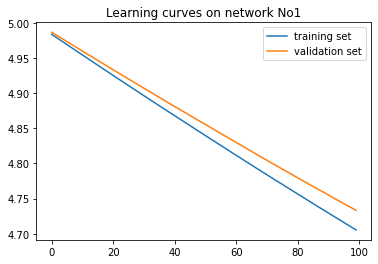

In [141]:
plt.figure(1)
plt.plot(history_1.history['loss'], label='training set')
plt.plot(history_1.history['val_loss'], label='validation set')
plt.legend()
plt.title('Learning curves on network No1')
plt.show()

y_pred1=model_1.predict(X_test)
print("R^2 is: "+str(r2_score(Y_test,y_pred1.argmax(axis=1))) +"\n" + "RMSE is: " + str(sqrt(mean_squared_error(Y_test,y_pred1.argmax(axis=1)))) )

In [142]:
#define second rbf network
model_2=tf.keras.Sequential()
model_2.add(rbflayer2)
model_2.add(layers.Dense(output_number))
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt,metrics=['accuracy'])
history_2=model_2.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Initialization complete
Iteration 0, inertia 0.0023119999999999556
Iteration 1, inertia 0.0014284444444444301
Converged at iteration 1: center shift 2.1277777777776876e-05 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.002265999999999981
Iteration 1, inertia 0.0014521786111111063
Converged at iteration 1: center shift 1.593805555555556e-05 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.0021329999999999258
Iteration 1, inertia 0.0013855833333332743
Converged at iteration 1: center shift 3.6111111111111763e-06 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.002154999999999944
Iteration 1, inertia 0.0014026333333333027
Converged at iteration 1: center shift 3.6111111111111763e-06 within tolerance 4.705565668289602e-05.
Initialization complete
Iteration 0, inertia 0.0021989999999999857
Iteration 1, inertia 0.0015172222222222392
Converged at iteration 1: center shift 1.2805

R^2 is: -0.7827750268927065
RMSE is: 12.13064707363943


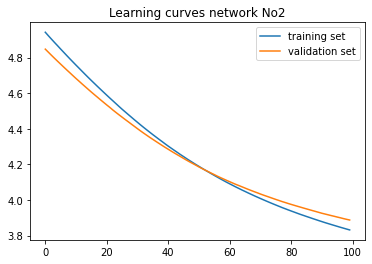

In [147]:
plt.figure(1)
plt.plot(history2.history['loss'], label='training set')
plt.plot(history2.history['val_loss'], label='validation set')
plt.legend()
plt.title('Learning curves network No2')
plt.show()

y_pred2=model_2.predict(X_test)
print("R^2 is: "+str(r2_score(Y_test,y_pred2.argmax(axis=1))) +"\n" + "RMSE is: " + str(sqrt(mean_squared_error(Y_test,y_pred2.argmax(axis=1)))) )

In [145]:
#define third rbf network
model_3=tf.keras.Sequential()
model_3.add(rbflayer3)
model_3.add(layers.Dense(output_number))
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt, metrics=['accuracy'])
history3=model_3.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 22ms/step - loss: 5.0817 - accuracy: 0.0000e+00 - val_loss: 5.0188 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 5.0403 - accuracy: 0.0000e+00 - val_loss: 4.9818 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 5.0006 - accuracy: 0.0000e+00 - val_loss: 4.9433 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 4.9595 - accuracy: 0.0000e+00 - val_loss: 4.9061 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 4.9203 - accuracy: 0.0000e+00 - val_loss: 4.8692 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 4.8814 - accuracy: 0.0000e+00 - val_loss: 4.8329 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 4.8430 - accuracy: 0.0000e+00 - 

R^2 is: -0.08063084382595176
RMSE is: 9.44440008223846


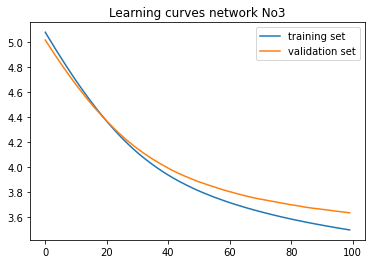

In [148]:
plt.figure(1)
plt.plot(history3.history['loss'], label='training set')
plt.plot(history3.history['val_loss'], label='validation set')
plt.legend()
plt.title('Learning curves network No3')
plt.show()

y_pred3=model_3.predict(X_test)
print("R^2 is: "+str(r2_score(Y_test,y_pred3.argmax(axis=1))) +"\n" + "RMSE is: " + str(sqrt(mean_squared_error(Y_test,y_pred3.argmax(axis=1)))) )